In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        print("0: ", x.shape)
        xs = self.localization(x)
        print("1: ", xs.shape)
        xs = xs.view(-1, 10 * 3 * 3)
        print("2: ", xs.shape)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        print("Theta: ", theta.shape)

        grid = F.affine_grid(theta, x.size())
        print("Grid: ", grid.shape)
        x = F.grid_sample(x, grid)
        print("3: ", x.shape)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

In [4]:
for i, (data, target) in enumerate(train_loader):
    if i < 5:
        print(data.shape, target.shape)
    else: break
data.shape

torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])


torch.Size([64, 1, 28, 28])

In [53]:
_ = model(data)

0:  torch.Size([64, 1, 28, 28])
1:  torch.Size([64, 10, 3, 3])
2:  torch.Size([64, 90])
Theta:  torch.Size([64, 2, 3])
Grid:  torch.Size([64, 28, 28, 2])
3:  torch.Size([64, 1, 28, 28])


In [4]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure the STN performances on MNIST.
#


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

/Users/charlesoneill/mambaforge/lib/python3.9/site-packages/torch/nn/functional.py:4277: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/charlesoneill/mambaforge/lib/python3.9/site-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313076
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.176239


/Users/charlesoneill/mambaforge/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1899, Accuracy: 9454/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.534407
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.597354

Test set: Average loss: 0.1374, Accuracy: 9579/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.321953
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.207494

Test set: Average loss: 0.0862, Accuracy: 9738/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.358108
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.224739

Test set: Average loss: 0.0744, Accuracy: 9779/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.217643
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.161944

Test set: Average loss: 0.0683, Accuracy: 9794/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.158501
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.070750

Test set: Average loss: 0.0601, Accuracy: 9824/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.062212
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.074052

Test set: Average loss: 0.0849, Accuracy: 9738/10000 (97%)

Tra

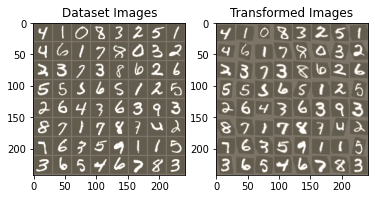

In [5]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

## Actual data

In [5]:
from pathlib import Path
from skimage.color import rgb2gray
import os
import cv2
import torch
import torch.nn as nn

def max_pool_image(img):
    # Convert the input image to a tensor
    img_tensor = torch.from_numpy(img)
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0)

    # Define the max pooling layer
    max_pool = nn.MaxPool2d(kernel_size=27, stride=27)

    # Pass the image through the max pooling layer
    img_tensor = max_pool(img_tensor)

    # Convert the tensor back to a numpy array
    img_np = img_tensor.squeeze().numpy()

    return img_np

def retrieve_images(patient_id = '156518'):
    # Set the root directory for the patient data
    root_dir = Path(f'../data/{patient_id}')

    # Get the list of image filenames for the left eye
    image_filenames = [f for f in os.listdir(root_dir) if 'L.png' in f]

    # Read the images into a list
    images = [cv2.imread(str(root_dir / f)) for f in image_filenames]

    # Convert the images to grayscale
    gray_images = [rgb2gray(img) for img in images]

    # Register all images to the first image
    template = gray_images[0]

    # Remove invalid images and compress
    final_images = [x for x in gray_images[1:] if x.shape == template.shape]
    #template = max_pool_image(template)
    
    print(final_images[0].shape, template.shape)

    return final_images, template

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 188 * 188, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 188 * 188)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)
        return x


model = Net().to(device)

In [7]:
data = next(iter(train_loader))[0].to(device)
data = data.unsqueeze(1)#.reshape(64, 1, 768, 768)
data.shape

torch.Size([64, 1, 1, 28, 28])

In [8]:
local = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

fc_loc = nn.Sequential(
            nn.Linear(10*188*188, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
fc_loc[2].weight.data.zero_()
fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

print("0: ", data.shape)
xs = local(data)
print("1: ", xs.shape)
xs = xs.view(-1, 10*188*188)
print("2: ", xs.shape)
theta = fc_loc(xs)
theta = theta.view(-1, 2, 3)
print("Theta: ", theta.shape)

x = data
grid = F.affine_grid(theta, x.size())
print("Grid: ", grid.shape)
x = F.grid_sample(x, grid)
print("3: ", x.shape)

0:  torch.Size([64, 1, 1, 28, 28])


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [64, 1, 1, 28, 28]

In [9]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

class FundusDataset(Dataset):
    def __init__(self, image_list, target_image):
        self.image_list = image_list
        self.target_image = target_image

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image = self.image_list[idx]
        image = torch.from_numpy(image).float()
        return image, self.target_image

# Load your list of Numpy arrays of training images
training_images, template = retrieve_images()
template_image = torch.from_numpy(template).float()

# Create the dataset
dataset = FundusDataset(training_images, template_image)

# Create the data loader
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

(768, 768) (768, 768)


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.L1Loss() #nn.MSELoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.unsqueeze(1)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.reshape(output.shape[0], 768, 768), target)
        loss.backward()
        optimizer.step()
        if epoch % 1 == 0:
            print('Train Epoch: {}, Loss: {:.6f}'.format(epoch, loss.item()))

for epoch in range(1, 5 + 1):
    train(epoch)

/Users/charlesoneill/mambaforge/lib/python3.9/site-packages/torch/nn/functional.py:4277: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/charlesoneill/mambaforge/lib/python3.9/site-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Train Epoch: 1, Loss: 0.123022
Train Epoch: 1, Loss: 0.128336
Train Epoch: 2, Loss: 0.130435
Train Epoch: 2, Loss: 0.114124
Train Epoch: 3, Loss: 0.121487
Train Epoch: 3, Loss: 0.128481
Train Epoch: 4, Loss: 0.122777
Train Epoch: 4, Loss: 0.125269
Train Epoch: 5, Loss: 0.127262


In [86]:
layer = model.localization

sum_of_parameters = 0
for parameter in layer.parameters():
    sum_of_parameters += parameter.sum()
print(sum_of_parameters)

tensor(-1.3134, grad_fn=<AddBackward0>)


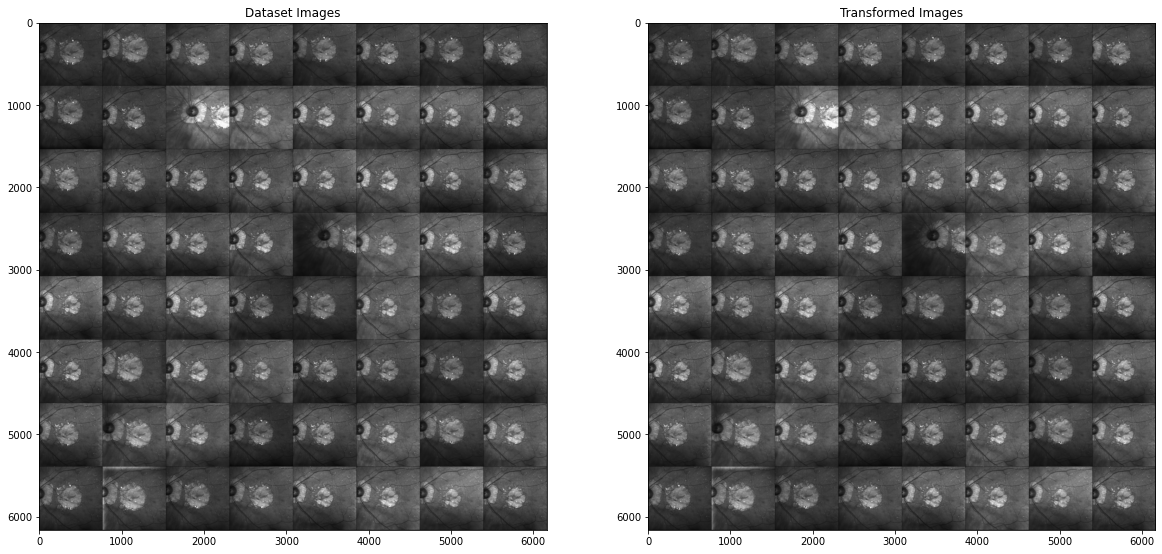

In [92]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(train_loader))[0].to(device)
        #data = data[:5]
        data = data.unsqueeze(1)
        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2, figsize=(20, 20))
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

visualize_stn()

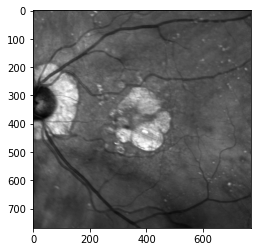

In [90]:
plt.imshow(template, cmap="gray");